In [1]:
import stream as st
import scanpy
import numpy as np
import scipy
import pandas as pd
from mabtplotlib import pyplot as plt
import os
from pandas.plotting import table 
st.__version__

/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


'1.1'

### If already processed: load mapped reference/query object

In [3]:
analysis_name = "stream_result_mappedNSCLC.Glioma.Melanoma"
adata_combined=st.read('./stream_result/' + analysis_name + '.pkl')

Working directory is already specified as './stream_result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


### Run stream for reference

In [ ]:
## Set analysis name- for reading/writing data
analysis_name="cd8_nsclc"

## Load h5ad object (from seurat)
filename="analysis/STREAM/" + analysis_name + ".h5ad"
adata = scanpy.read_h5ad(filename)
st.set_workdir(adata,'./stream_result')

## Make variable names unique
adata.var_names_make_unique()

## Convert to array
adata.X=adata.X.toarray()

## Calculate QC metrics
st.cal_qc(adata,assay='rna')

###Remove mitochondrial genes 
st.remove_mt_genes(adata)

## Variable genes
st.select_variable_genes(adata,loess_frac=0.01, n_genes=500)

## dimension reduction
st.dimension_reduction(adata,method='mlle',feature='var_genes',n_components=4,n_neighbors=50,n_jobs=4)



In [ ]:
st.plot_visualization_2D(adata,n_neighbors=50,method='umap',color=['majorCluster','n_genes'],use_precomputed=False)

## Run trajectory
st.seed_elastic_principal_graph(adata,n_clusters=10,use_vis=True)
st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)
st.elastic_principal_graph(adata,epg_alpha=0.02,epg_mu=0.05,epg_lambda=0.05)

## Edit branches
st.shift_branching(adata,epg_shift_mode='NodeDensity',epg_shift_radius=0.1,epg_shift_max=3)
st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
                                         
## Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['majorCluster'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

## save output
#filename='stream_result_' + analysis_name + '.pkl'
#st.write(adata,file_name=filename)

### Load in preprocessed reference stream object

In [4]:
analysis_name = "cd8_nsclc"
adata_ref=st.read('./stream_result/stream_result_forMapping_' + analysis_name + '.pkl')
figure_dir="figures/STREAM/" + analysis_name
if not os.path.isdir(figure_dir):
    os.mkdir(figure_dir)

Working directory is already specified as './stream_result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


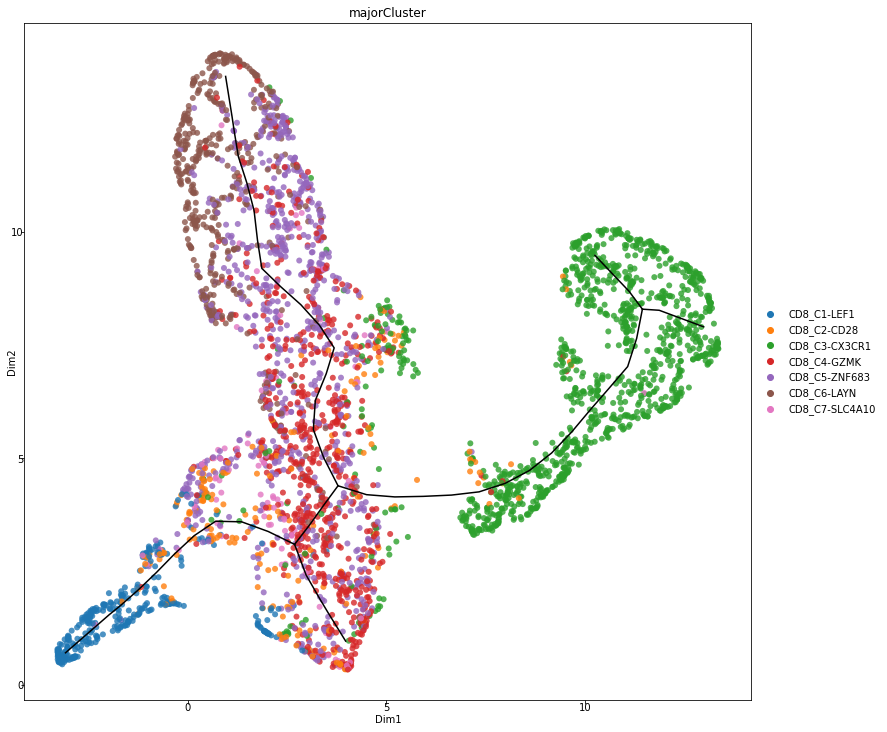

In [10]:
## Basic trajectory plots
st.plot_dimension_reduction(adata_ref,color=["majorCluster"],show_graph=True,show_text=False)
figure = plt.gcf()

figure.set_size_inches(16, 12)
plt.savefig(figure_dir + "/nsclc_trajectory_flat.png", dpi=600)

In [5]:
adata_ref.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,sample,RNA_snn_res.0.8,seurat_clusters,Cell.ID,patient,majorCluster,tissueType,...,branch_lam,branch_dist,S0_pseudotime,S3_pseudotime,S4_pseudotime,S2_pseudotime,S1_pseudotime,S7_pseudotime,S6_pseudotime,S5_pseudotime
PTC10-0616A,0,998483.262853,2699,P0616A,0,0,PTC10-0616A,P0616A,CD8_C2-CD28,P,...,0.942188,1.285070,12.898769,3.253369,13.429985,14.499062,14.587506,8.414171,0.942188,1.560075
PTC1-0616A,0,999171.728957,3115,P0616A,0,0,PTC1-0616A,P0616A,CD8_C3-CX3CR1,P,...,6.547560,0.590450,6.547560,3.097839,13.274455,8.147854,8.236297,11.645229,7.293396,4.791133
PTC11-0616A,0,999467.115363,3252,P0616A,4,4,PTC11-0616A,P0616A,CD8_C1-LEF1,P,...,1.196941,1.496489,12.644016,2.998616,13.175232,14.244310,14.332753,8.159418,1.196941,1.305322
PTC12-0616A,0,999344.883214,3582,P0616A,4,4,PTC12-0616A,P0616A,CD8_C1-LEF1,P,...,2.078455,0.338103,16.114334,6.468935,16.645551,17.714628,17.803071,2.078455,7.277903,4.775641
PTC14-0616A,0,999979.300234,3496,P0616A,0,0,PTC14-0616A,P0616A,CD8_C3-CX3CR1,P,...,0.000000,0.820673,1.600294,11.245693,21.422309,0.000000,3.289031,19.793083,15.441250,12.938987


### Load in data to be mapped to reference (h5ad)

In [4]:
## Load in merged cd8 glioma/melanoma object
adata_map=scanpy.read_h5ad("analysis/STREAM/cd8_glioma.melanoma.h5ad")
st.set_workdir(adata_map,'./stream_result')
adata_map.var_names_make_unique()
adata_map.X=adata_map.X.toarray()

Saving results in: ./stream_result


In [5]:
## Rename columns so they vary between adata and adata_new
#glioma_adata.var.columns = 'glioma_'+glioma_adata.var.columns
#melanoma_adata.var.columns = 'melanoma_'+melanoma_adata.var.columns
adata_map.var.columns = 'map_'+adata_map.var.columns

In [6]:
## Remove any genes that don't match
sharedGenes=adata_ref.var_names[adata_ref.var_names.isin(adata_map.var_names)]
adata_ref = adata_ref[:, sharedGenes]
adata_map= adata_map[:, sharedGenes]


In [7]:
## add on annotation column: all clusters
#adata.obs['Annot']=adata_ref.obs["majorCluster"]

## add on annotation column: annotation for glioma only
#adata.obs['Annot_ref']="ref"
#gm_adata.obs['Annot_ref']=gm_adata.obs["Annot"]

## Add on "age" to nsclc (ref)
adata_ref.obs['Tumor_Age']="NSCLC"

/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/ipykernel_launcher.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if __name__ == "__main__":


#### Merge into single object

In [8]:
print(adata_ref.X.shape)
adata_map.X.shape

(3805, 14105)


(6129, 14105)

In [9]:
adata_combined = st.map_new_data(adata_ref,adata_map)

Top variable genes are being used for mapping ...


/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


method 'mlle' is being used for mapping ...
Visualizing new cells on 2D plane ...
Using the manifold from `plot_visualization_2D()` 


/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [10]:
type(adata_combined.obs.head())
for col in adata_combined.obs.columns:
    print(col)

orig.ident
nCount_RNA
nFeature_RNA
sample
RNA_snn_res.0.8
seurat_clusters
age_numeric
Tumor_Age
node
branch_id
branch_id_alias
branch_lam
branch_dist
S0_pseudotime
S3_pseudotime
S4_pseudotime
S2_pseudotime
S1_pseudotime
S7_pseudotime
S6_pseudotime
S5_pseudotime
batch


In [14]:
adata_combined.uns['Tumor_Age_color'] = {'NSCLC':'gray','Melanoma':'orange', 'Glioma_Ped':'red', 'Glioma_Adult':'blue'}

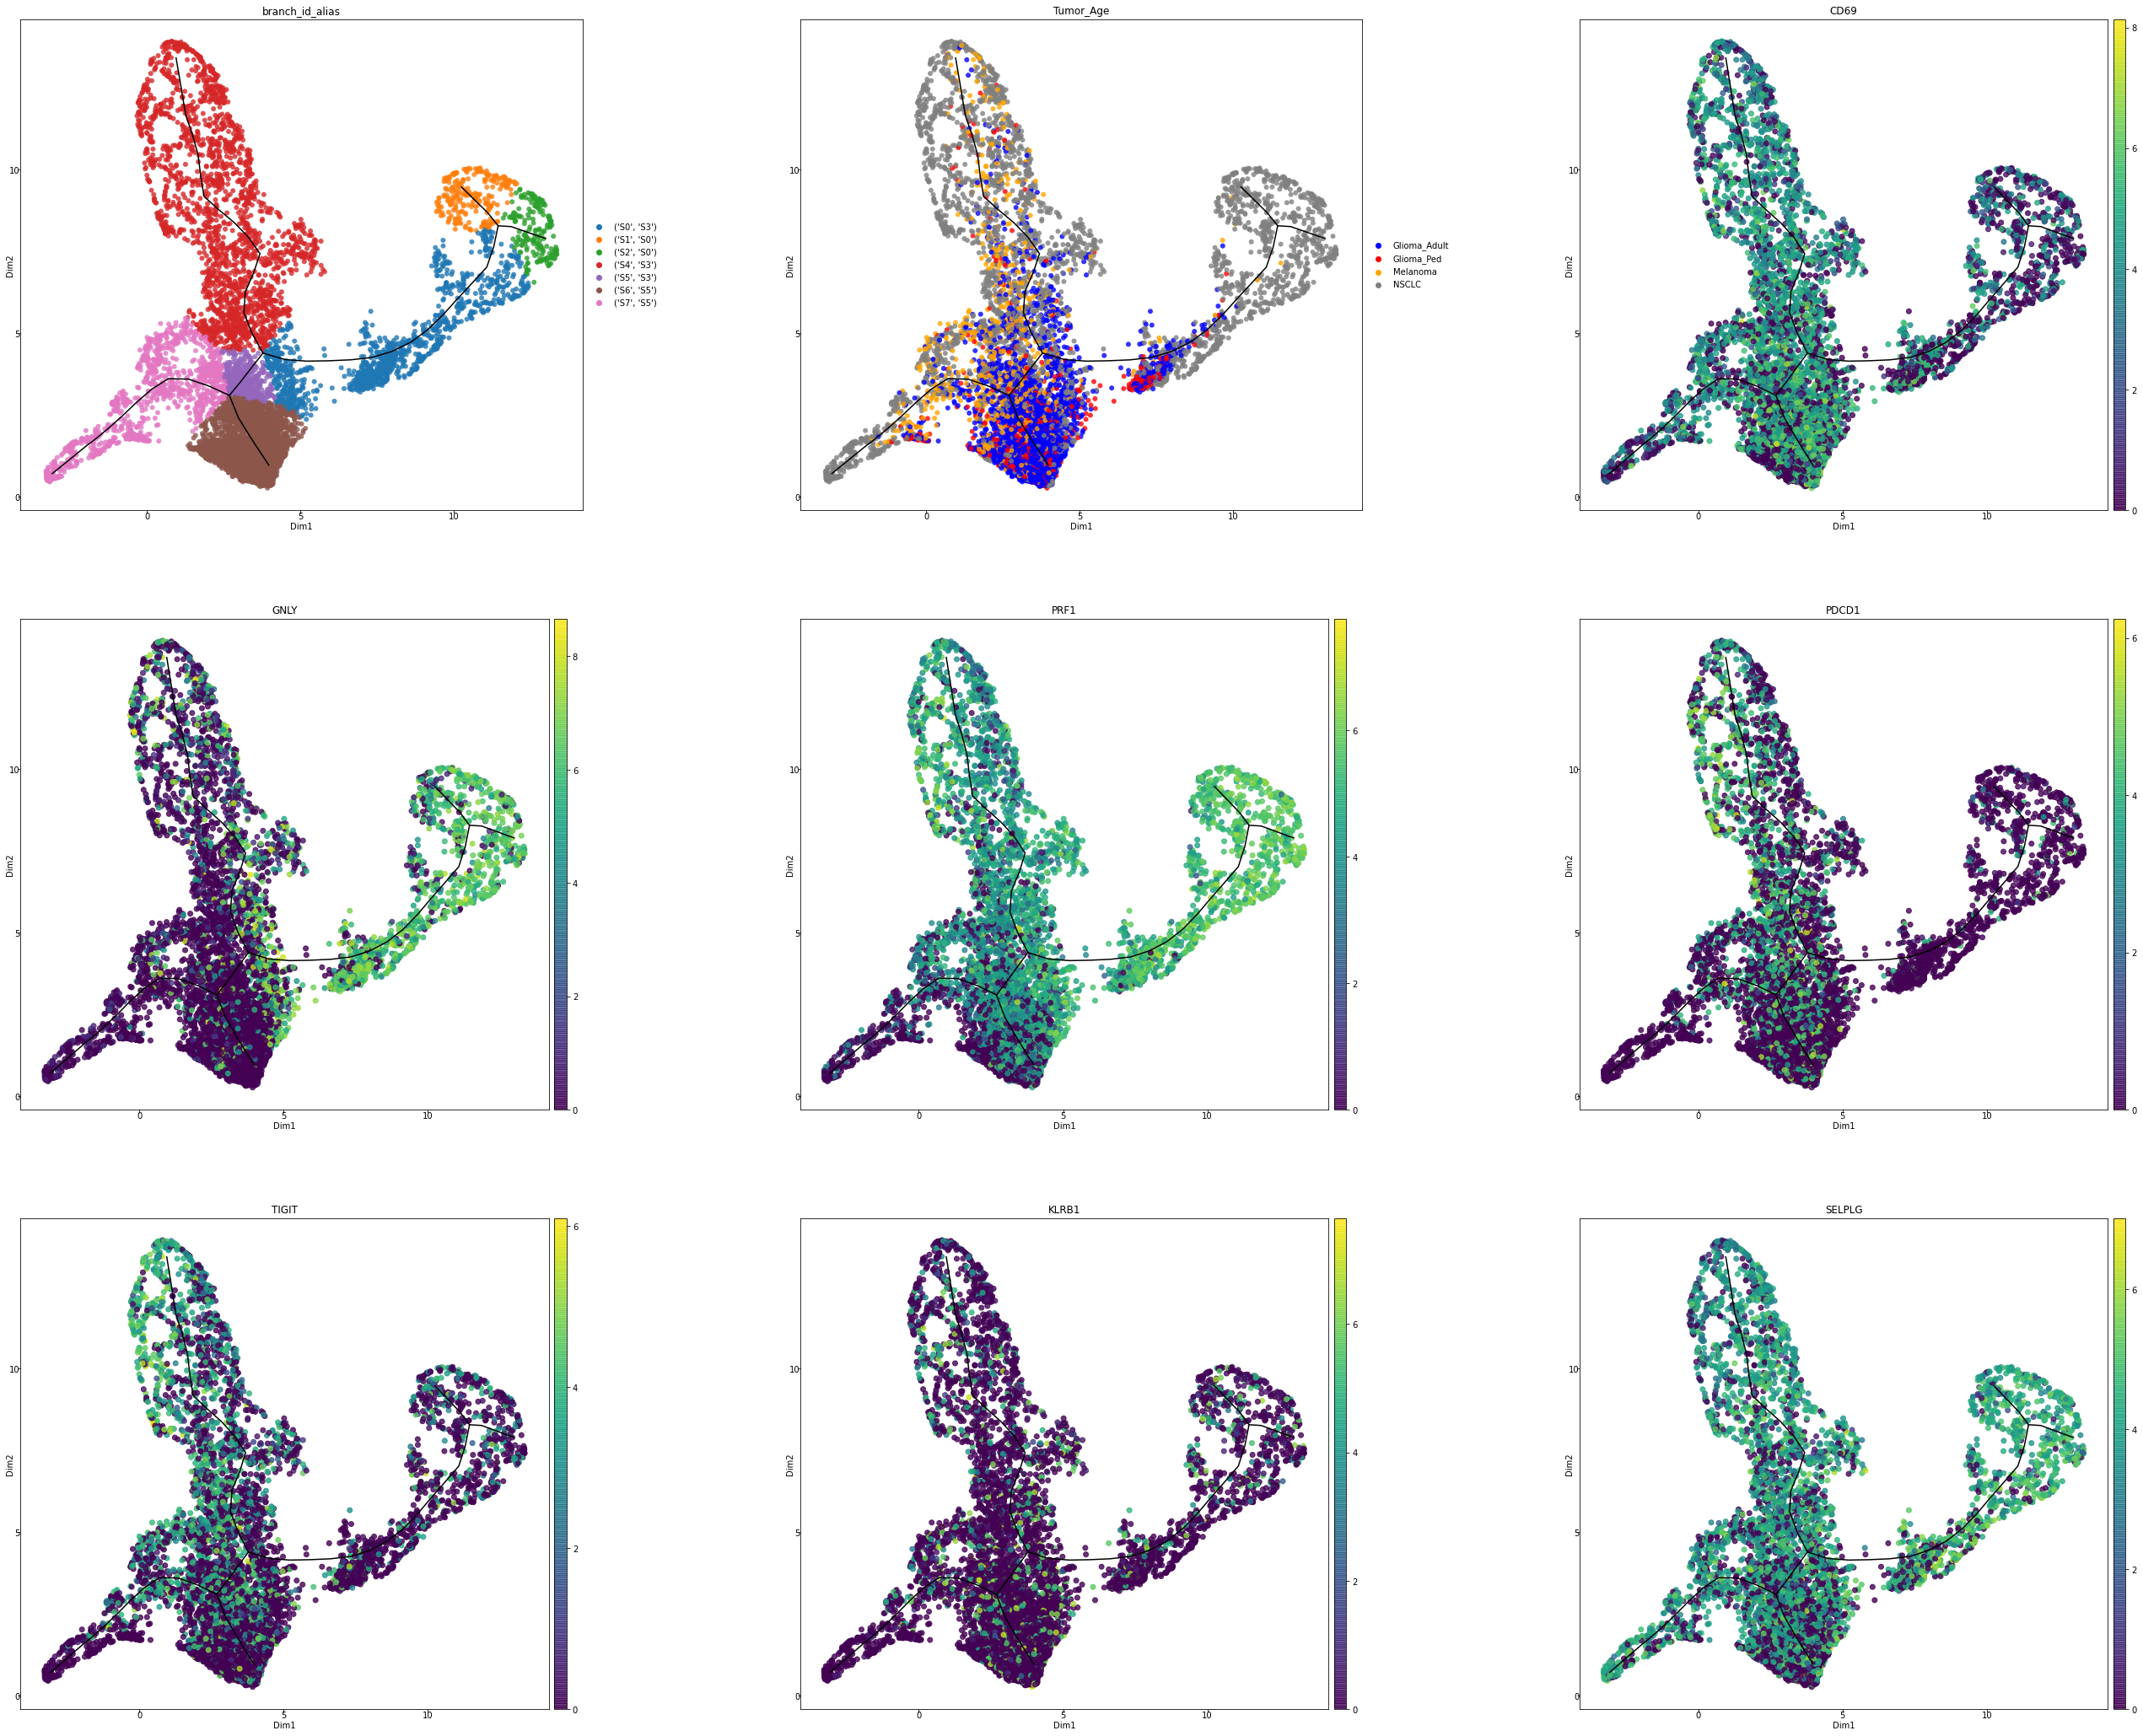

In [15]:
## since we learnt graph on visualization manifold, the dimension reduction plot will be the same as the visualization plot
st.plot_dimension_reduction(adata_combined,color=['branch_id_alias', 'Tumor_Age',
                                                  "CD69", "GNLY","PRF1", "PDCD1", "TIGIT", "KLRB1","SELPLG"],show_graph=True,show_text=False)
figure = plt.gcf()

figure.set_size_inches(36, 30)
plt.savefig(figure_dir + "/glioma.melanomaMap_trajectory_flat.png", dpi=600)

In [ ]:
st.plot_stream_sc(adata_combined,root='S7',color=['branch_id_alias', 
                                                  "CD69", "GNLY","PRF1", "PDCD1", "TIGIT", "KLRB1","SELPLG",'Tumor_Age'],
                  dist_scale=0.5,show_graph=True,show_text=True)

In [ ]:
st.plot_stream(adata_combined,root='S7',color=['GNLY', 'PDCD1', 'PRF1','Tumor_Age'],
               dist_scale=3,factor_num_win=1, factor_width=1, factor_zoomin=10)
figure = plt.gcf()

figure.set_size_inches(6, 3)
plt.savefig(figure_dir + "/glioma.melanomaMap_trajectory_stream.png", dpi=600)

In [15]:
## save output
filename='stream_result_mappedNSCLC.Glioma.Melanoma.pkl'
st.write(adata_combined,file_name=filename)

In [17]:
adata_combined.obs.to_csv( 'stream_result_mappedNSCLC.Glioma.Melanoma.csv')

### NOT IN USE

#### Subset to individual datasets (excluding ref)

In [ ]:
## Subset to individual datasets (excluding ref)
adata_combined_gm = adata_combined[np.isin(adata_combined.obs.Tumor_Age,['Glioma_Ped','Glioma_Adult', 'Melanoma'])].copy()

In [ ]:
adata_combined_gm.obs["Nature2020MaxScore"]=gm_adata.obs["cellAnnot"]


In [ ]:
gm_adata.obs['column'] = gm_adata.obs['maxGeneset'].astype('|S')
gm_adata.obs

In [ ]:
## Plot
st.plot_dimension_reduction(adata_combined_gm,color=['branch_id_alias', 'Annot', 'Annot_ref', 'Tumor_Age',
                                                  "CD69", "GNLY","PRF1", "PDCD1", "TIGIT", "KLRB1","SELPLG"],show_graph=True,show_text=False)
#figure = plt.gcf()

#figure.set_size_inches(12, 12)
#plt.savefig(figure_dir + "/glioma.melanomaMap_trajectory_flat.png", dpi=600)

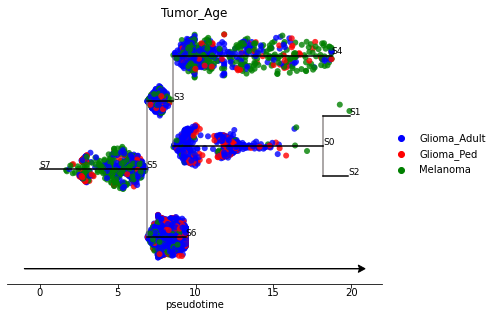

In [114]:
st.plot_stream_sc(adata_combined_gm,root='S7',color=['Tumor_Age'],
                  dist_scale=0.5,show_graph=True,show_text=True)

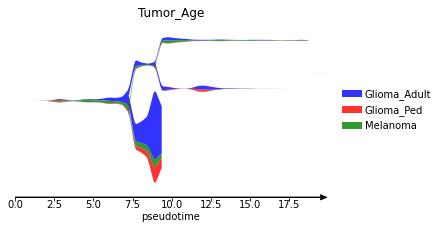

In [115]:
st.plot_stream(adata_combined_gm,root='S7',color=['Tumor_Age'],
               dist_scale=3,factor_num_win=1, factor_width=1, factor_zoomin=10)
figure = plt.gcf()

figure.set_size_inches(6, 3)
plt.savefig(figure_dir + "/Only.glioma.melanomaMap_trajectory_stream.png", dpi=600)

> Here the input datasets have been normalized. So we skipped the normalization step. For new datasets with raw counts, please exectute:
```python
st.normalize(adata_new,method='lib_size')
st.log_transform(adata_new)
st.remove_mt_genes(adata_new)
```

In [ ]:
### add new labels to highlight the new data
adata_combined.obs['label_new'] = ''
adata_combined.obs.loc[adata.obs_names+'-ref','label_new'] = 'ref'
adata_combined.obs.loc[adata_new.obs_names+'-new','label_new'] = adata_combined.obs.loc[adata_new.obs_names+'-new','label']
adata_combined.uns['label_new_color'] = {'ref':'gray',**adata_new.uns['label_color']}

In [ ]:
adata_combined

In [ ]:
## since we learnt graph on visualization manifold, the dimension reduction plot will be the same as the visualization plot
st.plot_dimension_reduction(adata_combined,color=['label_new','branch_id_alias','batch'],show_graph=True,show_text=False)

In [ ]:
st.plot_visualization_2D(adata_combined,n_neighbors=30,color=['label_new','branch_id_alias','batch'],fig_ncol=4)

In [ ]:
st.plot_visualization_2D(adata_combined,n_neighbors=30,color=['label','branch_id_alias','batch'],fig_ncol=4)

In [ ]:
st.plot_stream_sc(adata_combined,root='S4',color=['label','label_new','batch'],
                  dist_scale=0.5,show_graph=True,show_text=True)

In [ ]:
st.plot_stream(adata_combined,root='S4',color=['label','label_new','batch'],dist_scale=1.2)

#### Visualize each perturbation dataset independently

In [ ]:
import numpy as np

In [ ]:
adata_combined_Gfi1_Null = adata_combined[np.isin(adata_combined.obs.label_new,['Gfi1--','ref'])].copy()

In [ ]:
st.plot_visualization_2D(adata_combined_Gfi1_Null,n_neighbors=30,color=['label_new','branch_id_alias','batch'],fig_ncol=4)

In [ ]:
st.plot_stream_sc(adata_combined_Gfi1_Null,root='S4',color=['label_new'],
                  dist_scale=0.5,show_graph=True,show_text=True,alpha=0.9)

In [ ]:
st.plot_stream(adata_combined_Gfi1_Null,root='S4',color=['label_new'])

In [ ]:
adata_combined_Irf8_Null = adata_combined[np.isin(adata_combined.obs.label_new,['Irf8--','ref'])].copy()

In [ ]:
st.plot_visualization_2D(adata_combined_Irf8_Null,n_neighbors=30,color=['label_new','branch_id_alias','batch'],fig_ncol=4)

In [ ]:
st.plot_stream_sc(adata_combined_Irf8_Null,root='S4',color=['label_new'],
                  dist_scale=0.5,show_graph=True,show_text=True,alpha=0.9)

In [ ]:
st.plot_stream(adata_combined_Irf8_Null,root='S4',color=['label_new'],dist_scale=0.6,
               fig_legend_order={'label_new':['ref','Irf8--',]})

In [ ]:
adata_combined_Gfi1_Irf8_Null = adata_combined[np.isin(adata_combined.obs.label_new,['Gfi1--Irf8--','ref'])].copy()

In [ ]:
st.plot_visualization_2D(adata_combined_Gfi1_Irf8_Null,n_neighbors=30,color=['label_new','branch_id_alias','batch'],fig_ncol=4)

In [ ]:
st.plot_stream_sc(adata_combined_Gfi1_Irf8_Null,root='S4',color=['label_new'],
                  dist_scale=0.5,show_graph=True,show_text=True,alpha=0.9)

In [ ]:
st.plot_stream(adata_combined_Gfi1_Irf8_Null,root='S4',color=['label_new'],dist_scale=0.7)

In [ ]:
st.write(adata,file_name='adata.pkl')
st.write(adata_new,file_name='adata_new.pkl')
st.write(adata_combined,file_name='adata_combined.pkl')